In [68]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

from ipywidgets import Output

import pyneuralnet as pnn

In [30]:
class Layer(object):
    def __init__(self, num_prev, num_neurons, activation_function='sigmoid'):
        '''
        Initialize weights randomly with He scaling.
        
        self.A -- [num_neurons, 1] Array of activations
        self.Z -- [num_neurons, 1] Array of linearly aggregated inputs
        self.W -- [num_neurons, num_prev] Array of weights applied to previous layer's activations A.
        self.b -- [num_neurons, 1] Array of biases
        ''' 
        self.n = num_neurons
        self.act = activation_function  
        
        self.A = np.zeros((num_neurons,1))
        self.Z = np.zeros((num_neurons,1))
        self.b = np.zeros((self.n,1))
        
        # He initialization.
        if self.act == 'sigmoid':
            self.W = np.random.randn(num_neurons, num_prev) * np.sqrt(2.0/num_prev) / 5
        
    def forward(self, A_prev):
        '''
        Description:
        Perform forward pass by computing Z, then A.
        
        Parameters:
        A_prev -- [num_prev, m_samples] Array of activations from previous layer.
        
        Computes:
        self.A -- [self.n, m_samples] Array of activations for this layer.
        '''
        self.Z = self.W @ A_prev + self.b
        
        if self.act == 'linear':
            self.A = self.Z
            
        elif self.act == 'sigmoid':
            self.A = 1 / (1 + np.exp(-self.Z))
        
        return self.A
    
    def backward(self, W_next, dZ_next, A_prev):
        '''
        Description:
        Compute dA first, then dZ, then dW and db.
        
        Parameters:
        W_next -- [num_next, self.n] Array of weights between this layer and next layer.
        dZ_next -- [num_next, m_samples] Array of linear inputs to next layer.
        A_prev -- [num_prev,m_samples] Array of activations from previous layer.
        
        Computes:
        self.dA -- [self.n, m_samples] Gradient of cost w.r.t. activations.
        self.dZ -- [self.n, m_samples] Gradient of cost w.r.t. linear inputs.
        self.dW -- [self.n, num_prev] Gradient of cost w.r.t. weights.
        self.db -- [self.n, 1] Gradient of cost w.r.t. biases.
        '''        
        m = self.A.shape[1]
        self.dA = W_next.T @ dZ_next
        
        if self.act == 'linear':
            self.dZ = self.dA
            
        elif self.act == 'sigmoid':
            self.dZ = self.A * (1 - self.A) * self.dA
            
        self.dW = 1 / m * self.dZ @ A_prev.T
        self.db = 1 / m * np.sum(self.dZ, axis=1, keepdims=True)
        
    def update(self, learning_rate):
        self.W = self.W - learning_rate * self.dW
        self.b = self.b - learning_rate * self.db


    
def backprop(grad, X, network):
    L = len(network)
    W_output = np.eye(Y.shape[0], Y.shape[0])
    
#     print('Layer', L-1, 'backprop successful')
    network[L-1].backward(W_output, grad, network[L-2].A)
    
    for i in reversed(range(0, L - 1)):
#         print('Layer', i, 'backprop successful')
        W_next = network[i+1].W
        dZ_next = network[i+1].dZ
        if i == 0:
            A_prev = X
        else:
            A_prev = network[i-1].A
        network[i].backward(W_next, dZ_next, A_prev)

    return network
    
    
def gradientDescent(X, Y, network, num_iterations, learning_rate,
                    costfunction='logistic', showprogress='True',
                    showpreds='False'):
    L = len(network)
    costs = np.zeros((num_iterations))
    accs = np.zeros((num_iterations)) 
        
    for epoch in range(num_iterations):
        network = forwardprop(X, network)
        H = predict(X, network)
        costs[epoch], grad = computeCost(Y, network, costfunc=costfunction)
        accs[epoch], prec, rec = evaluateModel(H, Y)
        
        network = backprop(grad, X, network)
        
        # Perform one step of gradient descent
        for i in range(0, L):
            network[i].update(learning_rate)
        
        if showprogress == 'True':     
            if showpreds == 'True':
                msg = H
            else: msg = ''
            update_progress(epoch/num_iterations, str(msg))
           
        
    if showprogress == 'True':
        update_progress(1)   
        
        
    return network, costs, accs



def evaluateModel(H, Y):
    k = Y.shape[0]
    eps = 1e-8
    
    tp = np.sum(np.logical_and(H, Y))
    fp = np.sum(np.logical_and(H, Y==0))
    tn = np.sum(np.logical_and(H==0, Y==0))
    fn = np.sum(np.logical_and(H==0, Y))

    accuracy = np.sum(H==Y) / k
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)

    return accuracy, precision, recall


def plot2DBoundary(X, Y, network):
    delta = 0.01
    x1_min, x1_max = X[0, :].min() - 1, X[0, :].max() + 1
    x2_min, x2_max = X[1, :].min() - 1, X[1, :].max() + 1
    x1 = np.arange(x1_min, x1_max, delta)
    x2 = np.arange(x2_min, x2_max, delta)
    a, b = np.meshgrid(x1, x2)
    
    c = np.c_[a.ravel(), b.ravel()].T
    Z = predict(c, network)
    Z = Z.reshape(a.shape)

    plt.scatter(X[[0], :], X[[1], :], c=Y.astype('uint8'), s=10, marker='.')
    plt.contour(a, b, Z, colors='black')
    plt.show()

In [31]:
filename = 'tests/linear3.csv'
X, Y = loadCSVData(filename, skiprow=0)
X = X.T
Y = Y.T
print(X.shape, Y.shape)

(2, 1000) (1, 1000)


Progress: [####################] 100.0%



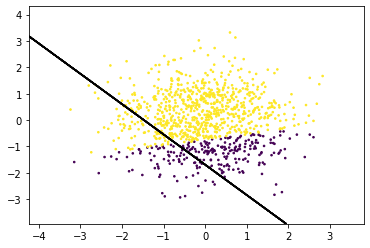

0.767 0.807692307682894 0.9106438896069561


In [66]:
layout = ((1, 'sigmoid'),) 

network = buildNetwork(layout, X.shape[0])

num_iterations = 1000
learning_rate = 0.01
newtork, costs, accs = gradientDescent(X, Y, network, num_iterations, learning_rate,
                        costfunction='logistic', showprogress='True')


plot2DBoundary(X, Y, network)
H = predict(X, network)
acc, prec, rec = evaluateModel(H, Y)
print(acc, prec, rec)

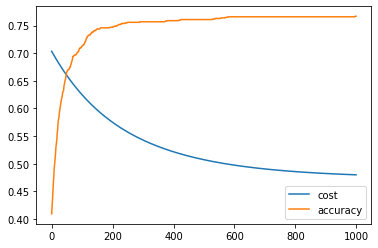

In [67]:
plt.plot(costs, label='cost')
plt.plot(accs, label='accuracy')
plt.legend()
plt.show()

## Gradient Checking Tool


In [ ]:
def function(H, Y):
    m = H.shape[1]
    return -1 / m * (Y @ np.log(H.T) + (1 - Y) @ np.log(1 - H.T))

def gradient(H, Y):
    m = H.shape[1]
    return 1 / m * np.sum(np.divide(-Y, H) + np.divide(1 - Y, 1 - H), keepdims=True)

np.random.seed(20)
Z = np.random.rand(1, 3)
print('Input\n', Z, '\n')

Y = np.array([[0, 1, 1]])
print('Correct Answer\n', Y, '\n')

A = function(Z, Y)
print('Output\n', A, '\n')

dAdZ = gradient(Z, Y)
print('Gradient\n', dAdZ, '\n')

eps = 1e-5
plus = function(Z + eps, Y)
minus = function(Z - eps, Y)
dAdZ_check = (plus - minus) / (2 * eps)
print('Gradient Check\n', dAdZ_check)

In [ ]:
Z

## Make fake data

In [ ]:
import csv

f = 'tests/linear3.csv'

def makeFakeData_LinearBoundary(f):

    b = round(float(np.random.randn(1)), 2)
    a1 = 0.1
    a2 = 0.5

    with open(f, 'w') as csvFile:
        writer = csv.writer(csvFile)
        for i in range(50):
            for j in range(20):
                x1 = round(float(np.random.randn(1)), 2)
                x2 = round(float(np.random.randn(1)), 2)
                y = 1*((a2*x2) > (a1*x1 + b)) 
                inp = [x1, x2, y]
                print(inp)
                writer.writerow(inp)

    csvFile.close()

makeFakeData_LinearBoundary(f)

In [ ]:
np.where()

In [52]:
a = [[2, 3, 4], [2, 1, 4]]
print(*a)

[2, 3, 4] [2, 1, 4]


## Function testing

In [83]:
def evaluateModel(H, Y, decimal=3):
    k = Y.shape[0]
    eps = 1e-8
    
    tp = np.sum(np.logical_and(H, Y))
    fp = np.sum(np.logical_and(H, Y==0))
    tn = np.sum(np.logical_and(H==0, Y==0))
    fn = np.sum(np.logical_and(H==0, Y))

    accuracy = round(np.sum(H==Y) / k, decimal)
    precision = round(tp / (tp + fp + eps), decimal)
    recall = round(tp / (tp + fn + eps), decimal)

    return accuracy, precision, recall

In [84]:
h = np.array([[1],
             [1],
             [0],
             [1],
             [0]
             ])

y = np.array([[1],
             [0],
             [0],
             [0],
             [1]])

acc, prec, rec = evaluateModel(h, y, decimal=8)

print(acc, prec, rec)

0.4 0.33333333 0.5
